In [1]:
import sys
sys.path.append('../')

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from helpers.selectors import compare
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [2]:
from dask.diagnostics import ProgressBar

In [3]:
with ProgressBar():
    %time R32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots_00002705.nc', decode_times=False, chunks={'time':1})[['u', 'v', 'h']].isel(time=slice(None,None,6)).load()

[########################################] | 100% Completed | 375.80 s
CPU times: user 6min 8s, sys: 6.04 s, total: 6min 14s
Wall time: 6min 18s


In [4]:
%time static = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/static.nc', decode_times=False).load()

CPU times: user 1.45 s, sys: 819 ms, total: 2.27 s
Wall time: 2.71 s


In [4]:
import gcm_filters
def filter_dataset(ds, static, FGR=4):
    if FGR == 0:
        return ds
    filter_simple_fixed_factor_t = gcm_filters.Filter(
        filter_scale=FGR,
        dx_min=1,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': static.area_t, 'wet_mask': static.wet}
    )

    filter_simple_fixed_factor_u = gcm_filters.Filter(
        filter_scale=FGR,
        dx_min=1,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': static.area_u, 'wet_mask': static.wet_u}
    )

    filter_simple_fixed_factor_v = gcm_filters.Filter(
        filter_scale=FGR,
        dx_min=1,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': static.area_v, 'wet_mask': static.wet_v}
    )
    
    dsf = xr.Dataset()
    dsf['h'] = filter_simple_fixed_factor_t.apply(ds.h.copy(), dims=['yh', 'xh'])
    dsf['u'] = filter_simple_fixed_factor_u.apply(ds.u.copy(), dims=['yh', 'xq'])
    dsf['v'] = filter_simple_fixed_factor_v.apply(ds.v.copy(), dims=['yq', 'xh'])
    return dsf

In [6]:
import gcm_filters
def coarsen_dataset(ds, static, FGR=4):
    if FGR == 0:
        return ds
    
    dsc = xr.Dataset()
    dsc['h'] = ds.h.coarsen({'xh': FGR, 'yh':FGR}).mean()
    dsc['u'] = ds.u.coarsen({'xq': FGR, 'yh':FGR}, boundary='trim').mean()
    dsc['v'] = ds.v.coarsen({'xh': FGR, 'yq':FGR}, boundary='trim').mean()

    staticc = xr.Dataset()
    staticc['area_t'] = static['area_t'].coarsen({'xh': FGR, 'yh':FGR}).sum()
    return dsc, staticc

In [18]:
with ProgressBar():
    R32f_R4 = filter_dataset(R32, static, FGR=8).compute()

[########################################] | 100% Completed | 381.32 s


In [22]:
R32f_R4.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.25-degree-snapshots.nc')

In [37]:
R32f_R4 = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.25-degree-snapshots.nc', chunks={'zl':1, 'zi':1, 'time':1})
R32f_R2 = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-snapshots.nc', chunks={'zl':1, 'zi':1, 'time':1})
R32f_R1 = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-snapshots.nc', chunks={'zl':1, 'zi':1, 'time':1})

In [17]:
print(Lk_error(R32f_R2.u.isel(time=-1), R32f.u, normalize=True))
print(Lk_error(R32f_R2.v.isel(time=-1), R32f.v, normalize=True))
print(Lk_error(R32f_R2.h.isel(time=-1), R32f.h, normalize=True))

[2.5131707781702747e-08, 2.5150462842197308e-08, 2.519490363349142e-08, 2.5182310971321036e-08, 2.5242530606272645e-08, 2.529686452620401e-08, 2.5222399939078513e-08, 2.524082130781723e-08, 2.5438040717041572e-08, 2.5239525388522023e-08, 2.5276142220506783e-08, 2.5407595578574628e-08, 2.5376169119880046e-08, 2.5466986834554906e-08, 2.53566228541586e-08]
[2.5483439725739134e-08, 2.5487377752175213e-08, 2.556612191038505e-08, 2.5493418061291036e-08, 2.536521509226854e-08, 2.5303391808694083e-08, 2.5485897268566815e-08, 2.5353585686228077e-08, 2.5148189989147363e-08, 2.5366777609339485e-08, 2.5221833438211313e-08, 2.5388803767489072e-08, 2.5351949916328062e-08, 2.5418398982443245e-08, 2.545015735890925e-08]
[2.631798853448277e-08, 2.6505004560832243e-08, 2.4756673210418353e-08, 2.5488917874873912e-08, 2.6986709268350267e-08, 2.6930358106760743e-08, 2.363346290140664e-08, 2.2489399963348145e-08, 2.283620421967196e-08, 2.8264149772538833e-08, 2.5386611043249197e-08, 2.2208695210385477e-08, 

In [12]:
def KE_joul(ds, static):
    u = ds.u
    v = ds.v
    h = ds.h
    R = 1000. # It is reference density
    area_t = static.area_t
    return (0.5 * R * (remesh(u**2, h) + remesh(v**2, h)) * h * area_t).sum(dim=('xh','yh', 'zl'))

In [21]:
with ProgressBar():
    print('KE in 1/32 experiment = ', float(KE_joul(R32, static).mean()))
    print('KE in 1/32 experiment filtered with 1-degree filter = ', float(KE_joul(R32f_R1, static).mean()))
    print('KE in 1/32 experiment filtered with 0.5-degree filter = ', float(KE_joul(R32f_R2, static).mean()))

[########################################] | 100% Completed | 388.23 s
KE in 1/32 experiment =  2.4482846764501053e+18
[########################################] | 100% Completed | 31.16 s
KE in 1/32 experiment filtered with 1-degree filter =  1.8403431929593664e+18
[########################################] | 100% Completed | 30.26 s
KE in 1/32 experiment filtered with 0.5-degree filter =  2.2143647792956214e+18


KeyboardInterrupt: 

In [24]:
with ProgressBar():
    print('KE in 1/32 experiment filtered with 0.25-degree filter = ', float(KE_joul(R32f_R4, static).mean()))

[########################################] | 100% Completed | 11.36 s
KE in 1/32 experiment filtered with 0.25-degree filter =  2.369492996055423e+18


In [7]:
%time R32_R4, static_R4 = coarsen_dataset(R32, static, FGR=8)
%time R32_R2, static_R2 = coarsen_dataset(R32, static, FGR=16)
%time R32_R1, static_R1 = coarsen_dataset(R32, static, FGR=32)

CPU times: user 10.3 s, sys: 1.67 s, total: 12 s
Wall time: 12.2 s
CPU times: user 6.37 s, sys: 1.62 s, total: 8 s
Wall time: 8.02 s
CPU times: user 4.64 s, sys: 1.62 s, total: 6.27 s
Wall time: 6.28 s


In [8]:
with ProgressBar():
    R32_R4.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.25-degree-coarsen-snapshots.nc')
    static_R4.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.25-degree-static.nc')

In [9]:
with ProgressBar():
    R32_R2.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-coarsen-snapshots.nc')
    static_R2.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/0.5-degree-static.nc')

In [10]:
with ProgressBar():
    R32_R1.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-coarsen-snapshots.nc')
    static_R1.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/1-degree-static.nc')

In [13]:
with ProgressBar():
    print('KE in 1/32 experiment coarsegrained to 0.25-degree = ', float(KE_joul(R32_R4, static_R4).mean()))
    print('KE in 1/32 experiment coarsegrained to 0.5-degree = ', float(KE_joul(R32_R2, static_R2).mean()))
    print('KE in 1/32 experiment coarsegrained to 1-degree = ', float(KE_joul(R32_R1, static_R1).mean()))

KE in 1/32 experiment coarsegrained to 0.25-degree =  2.3651313609656105e+18
KE in 1/32 experiment coarsegrained to 0.5-degree =  2.2003874305719982e+18
KE in 1/32 experiment coarsegrained to 1-degree =  1.8063057503960049e+18


In [23]:
series = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/ocean_stats.nc')
series['Time'] = series['Time'] / np.timedelta64(1, 'D')

In [57]:
KE_R32f_R2 = KE_joul(R32f_R2, static).compute()
KE_R32_R4 = KE_joul(R32_R4, static_R4).compute()

In [40]:
KE_R32 = KE_joul(R32, static).compute()

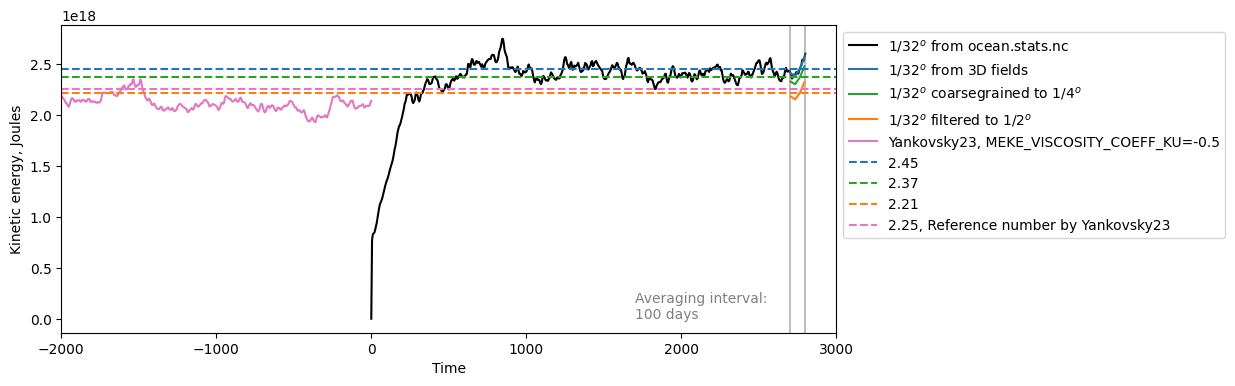

In [139]:
#plt.subplot(2,1,1)
plt.figure(figsize=(10,4))
series.KE.sum('Layer').plot(label='$1/32^o$ from ocean.stats.nc', color='k')
plt.axvline(x=2700, color='gray', alpha=0.5)
plt.axvline(x=2800, color='gray', alpha=0.5)
KE_R32.plot(label='$1/32^o$ from 3D fields')
KE_R32_R4.plot(label='$1/32^o$ coarsegrained to $1/4^o$', color='tab:green')
KE_R32f_R2.plot(label='$1/32^o$ filtered to $1/2^o$', color='tab:orange')

# plt.text(5000-30000,2.448e+18,'2.45',backgroundcolor='white',color='tab:blue')
# plt.text(0-30000,2.15e+18,'2.21',backgroundcolor='white',color='tab:orange')
# plt.text(2500-30000,2.37e+18,'2.37',backgroundcolor='white',color='tab:green')
plt.text(1700,0, 'Averaging interval:\n100 days', color='gray')


Liz = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Yankovsky23/output/ocean.stats.nc', decode_times=False).KE.sum('Layer')
Liz['Time'] = Liz['Time']-30000

Liz.plot(color='tab:pink', label='Yankovsky23, MEKE_VISCOSITY_COEFF_KU=-0.5')

plt.axhline(y=2.4482846764501053e+18, color='tab:blue', ls='--', label='2.45')
plt.axhline(y=2.3651313609656105e+18, color='tab:green', ls='--', label='2.37')
plt.axhline(y=2.2143647792956214e+18, color='tab:orange', ls='--', label='2.21')
plt.axhline(y=2.25e+18, color='tab:pink', ls='--', label='2.25, Reference number by Yankovsky23')

plt.xlim([-2000,3000])
plt.ylabel('Kinetic energy, Joules')
plt.legend(bbox_to_anchor=(1,1))

plt.savefig('reference_numbers.pdf', bbox_inches='tight')